Home Sales Data Details in Istanbul

src : https://www.kaggle.com/datasets/emrahaydemr/home-sales-data-details-in-istanbul/data

column :179

In [43]:
!pip install pip==23.2.1 setuptools==65.5.1

In [44]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost imbalanced-learn

In [45]:
# connect S3 bucket
bucket = "mscproject01"
datakey = "Home Sale Data.csv"
data_location = f"s3://{bucket}/{datakey}"

print(data_location)

s3://mscproject01/Home Sale Data.csv


In [46]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [47]:
# Load dataset
df = pd.read_csv(data_location, delimiter=';')
df.head(5)

,District,Neighborhood,Price,Adrtisement Date,m² (Gross),m² (Net),Number of rooms,Building Age,Floor location,Number of floors,Heating,Number of bathrooms,Balcony,Furnished,Using status,Available for Loan,From who,Swap,Front West,Front East,Front South,Front North,ADSL,Wood Joinery,Smart House,Alarm (Thief),Alarm (Fire),Alaturka Toilet,Aluminum joinery,American Door,American kitchen,Built-in on,Elevator,Balcony.1,Barbecue,Household appliances,Painted,Dishwasher,Refrigerator,Wall paper,Shower,Parents' Bathroom,Fiber Internet,On,Dressing room,Closet,Video intercom,Hilton Bathroom,Intercom System,Insulating glass,Jacuzzi,Plasterboard,Cellar,Air conditioning,Tub,Laminate Floor,Marley,Furniture,Kitchen (Built-in),Kitchen (Laminate),Kitchen Natural Gas,PVC Joinery,Blinds,Parquet Floor,Ceramic Floor,Set Top Cooker,Spot Lighting,Terrace,Thermosiphon,Cloakroom,Wi-Fi,Face Recognition & Fingerprint,Washing Machine,Washing machine,Laundry room,Steel door,Water heater,Fireplace,Elevator.1,Steam room,Security,Bath,Booster,Thermal Insulation,Generator,Cable TV,Closed Garage,Doorman,Nursery,With Private Pool,Car park,Playground,Sauna,Sound insulation,Siding,Sports Area,Water tank,Tennis court,Satellite,Fire escape,Swimming Pool (Open),Swimming Pool (Indoor),Parking Lot,Elevator.2,Bathroom,Wide Corridor,Entrance / Ramp,Stairs,Kitchen,Room door,Park,Socket / Electric Switch,Handle / Railing,Toilet,Swimming pool,The mall,municipality,Mosque,Cemevi,Next to sea shore,Pharmacy,Amusement center,Fair,Hospital,Synagogue,The church,High school,Market,Park.1,Police station,The health clinic,District Market,Gym,Unirsity,Primary School-Secondary School,Fire Department,Town center,Highway,Eurasia Tunnel,Bosphorus Bridges,Street,Sea bus,Filled,E-5,Airport,Marmaray,Metro,Metrobus,Minibus,Bus stop,Coast,TEM,Cable car,Tram,Railway station,Trolley bus,Scaffolding,Throat,Sea,Nature,Lake,Pool,Park & ​​Green Area,City,Mezzanine,Mezzanine Duplex,Garden Duplex,Garden Floor,Garden,Top floor,Garage / Shop Top,Entrance floor,Floor Duplex,Private Entry,Rerse Duplex,Triplex,Ground floor,Roof Duplex,Pick Up Data Time
0,Tuzla,Aydınlı Mh.,165.000 TL,04.01.2020,50,40.0,1+1,5-10 between,5,13,Natural Gas (Combi),1,Absent,Yes,Free,Yes,From owner,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,01.08.2020
1,Fatih,Katip Kasım Mh.,207.000 TL,06.01.2020,42,42.0,1+1,31 and more than,Ground floor,3,Floor Heating,1,Absent,No,Free,Yes,From bank,No,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
2,Çekmeköy,Çatalmeşe Mh.,153.000 TL,31.12.2019,55,45.0,1+1,1,Kot 1,7,Natural Gas (Combi),1,Absent,No,Property owner,Yes,From owner,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
3,Çekmeköy,Mehmet Akif Ersoy Mah.,205.000 TL,29.12.2019,62,46.0,1+1,0,High entrance,5,Natural Gas (Combi),1,Absent,No,Property owner,Yes,From owner,Yes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
4,Küçükçekmece

In [48]:
df.shape

(34843, 179)

In [49]:
df.tail()

,District,Neighborhood,Price,Adrtisement Date,m² (Gross),m² (Net),Number of rooms,Building Age,Floor location,Number of floors,Heating,Number of bathrooms,Balcony,Furnished,Using status,Available for Loan,From who,Swap,Front West,Front East,Front South,Front North,ADSL,Wood Joinery,Smart House,Alarm (Thief),Alarm (Fire),Alaturka Toilet,Aluminum joinery,American Door,American kitchen,Built-in on,Elevator,Balcony.1,Barbecue,Household appliances,Painted,Dishwasher,Refrigerator,Wall paper,Shower,Parents' Bathroom,Fiber Internet,On,Dressing room,Closet,Video intercom,Hilton Bathroom,Intercom System,Insulating glass,Jacuzzi,Plasterboard,Cellar,Air conditioning,Tub,Laminate Floor,Marley,Furniture,Kitchen (Built-in),Kitchen (Laminate),Kitchen Natural Gas,PVC Joinery,Blinds,Parquet Floor,Ceramic Floor,Set Top Cooker,Spot Lighting,Terrace,Thermosiphon,Cloakroom,Wi-Fi,Face Recognition & Fingerprint,Washing Machine,Washing machine,Laundry room,Steel door,Water heater,Fireplace,Elevator.1,Steam room,Security,Bath,Booster,Thermal Insulation,Generator,Cable TV,Closed Garage,Doorman,Nursery,With Private Pool,Car park,Playground,Sauna,Sound insulation,Siding,Sports Area,Water tank,Tennis court,Satellite,Fire escape,Swimming Pool (Open),Swimming Pool (Indoor),Parking Lot,Elevator.2,Bathroom,Wide Corridor,Entrance / Ramp,Stairs,Kitchen,Room door,Park,Socket / Electric Switch,Handle / Railing,Toilet,Swimming pool,The mall,municipality,Mosque,Cemevi,Next to sea shore,Pharmacy,Amusement center,Fair,Hospital,Synagogue,The church,High school,Market,Park.1,Police station,The health clinic,District Market,Gym,Unirsity,Primary School-Secondary School,Fire Department,Town center,Highway,Eurasia Tunnel,Bosphorus Bridges,Street,Sea bus,Filled,E-5,Airport,Marmaray,Metro,Metrobus,Minibus,Bus stop,Coast,TEM,Cable car,Tram,Railway station,Trolley bus,Scaffolding,Throat,Sea,Nature,Lake,Pool,Park & ​​Green Area,City,Mezzanine,Mezzanine Duplex,Garden Duplex,Garden Floor,Garden,Top floor,Garage / Shop Top,Entrance floor,Floor Duplex,Private Entry,Rerse Duplex,Triplex,Ground floor,Roof Duplex,Pick Up Data Time
34838,Sarıyer,Ayazağa Mh.,5.650.000 TL,02.01.2020,270,185.0,4+1,0,9,9,Center (Share Meter),2,Available,No,Free,Yes,From the real estate office,No,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,01.08.2020
34839,Bakırköy,Ataköy 2-5-6. Kısım Mh.,12.000.000 TL,03.01.2020,289,250.0,4.5+1,0,8,16,Center (Share Meter),3,Available,Yes,Free,No,From the real estate office,No,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,01.10.2020
34840,Sarıyer,Maslak Mah.,2.700.000 TL,03.01.2020,311,310.0,3+1,1,14,16,Center (Share Meter),2,Available,No,Free,No,From the real estate office,No,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,01.08.2020
34841,Fatih,İskenderpaşa Mh.,775.000 TL,28.12.2019,145,121.0,3+1,0,4,7,Natural Gas (Combi),2,Available,Yes,Property owner,Yes,From owner,Yes,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34843 entries, 0 to 34842
Columns: 179 entries, District to Pick Up Data Time
dtypes: float64(1), int64(161), object(17)
memory usage: 47.6+ MB


In [51]:
df.isnull().sum().sort_values(ascending=False).head(20)


m² (Net)             28
Handle / Railing      0
Toilet                0
Swimming pool         0
The mall              0
municipality          0
Mosque                0
Cemevi                0
Next to sea shore     0
Pharmacy              0
Garage / Shop Top     0
Fair                  0
Hospital              0
Synagogue             0
The church            0
High school           0
Market                0
Park.1                0
Police station        0
The health clinic     0
dtype: int64

In [52]:
# Step 1: Remove duplicate columns (e.g., multiple 'Elevator', 'Balcony')
df = df.loc[:, ~df.columns.duplicated()]

In [53]:
# Step 2: Drop columns with all missing values (if any)
df.dropna(axis=1, how='all', inplace=True)

In [54]:
# Step 2: Drop columns with all missing values (if any)
df.dropna(axis=1, how='all', inplace=True)

In [55]:
# Step 3: Fill missing values (you can customize)
df.fillna("Unknown", inplace=True)

In [56]:
df.shape

(34843, 179)

In [57]:
pd.set_option('display.max_columns', None)
df.columns.tolist()

['District',
 'Neighborhood',
 'Price',
 'Adrtisement Date',
 'm² (Gross)',
 'm² (Net)',
 'Number of rooms',
 'Building Age',
 'Floor location',
 'Number of floors',
 'Heating',
 'Number of bathrooms',
 'Balcony',
 'Furnished',
 'Using status',
 'Available for Loan',
 'From who',
 'Swap',
 'Front West',
 'Front East',
 'Front South',
 'Front North',
 'ADSL',
 'Wood Joinery',
 'Smart House',
 'Alarm (Thief)',
 'Alarm (Fire)',
 'Alaturka Toilet',
 'Aluminum joinery',
 'American Door',
 'American kitchen',
 'Built-in on',
 'Elevator',
 'Balcony.1',
 'Barbecue',
 'Household appliances',
 'Painted',
 'Dishwasher',
 'Refrigerator',
 'Wall paper',
 'Shower',
 "Parents' Bathroom",
 'Fiber Internet',
 'On',
 'Dressing room',
 'Closet',
 'Video intercom',
 'Hilton Bathroom',
 'Intercom System',
 'Insulating glass',
 'Jacuzzi',
 'Plasterboard',
 'Cellar',
 'Air conditioning',
 'Tub',
 'Laminate Floor',
 'Marley',
 'Furniture',
 'Kitchen (Built-in)',
 'Kitchen (Laminate)',
 'Kitchen Natural Gas',


In [58]:
# This tells pandas to display all columns without truncation
pd.set_option('display.max_columns', None)

# Now display a specific row — for example, the first row
print(df.iloc[0])

District                   Tuzla
Neighborhood         Aydınlı Mh.
Price                 165.000 TL
Adrtisement Date      04.01.2020
m² (Gross)                    50
                        ...     
Rerse Duplex                   0
Triplex                        0
Ground floor                   0
Roof Duplex                    0
Pick Up Data Time     01.08.2020
Name: 0, Length: 179, dtype: object


In [59]:
df.sample(1)  # shows 1 random full row


,District,Neighborhood,Price,Adrtisement Date,m² (Gross),m² (Net),Number of rooms,Building Age,Floor location,Number of floors,Heating,Number of bathrooms,Balcony,Furnished,Using status,Available for Loan,From who,Swap,Front West,Front East,Front South,Front North,ADSL,Wood Joinery,Smart House,Alarm (Thief),Alarm (Fire),Alaturka Toilet,Aluminum joinery,American Door,American kitchen,Built-in on,Elevator,Balcony.1,Barbecue,Household appliances,Painted,Dishwasher,Refrigerator,Wall paper,Shower,Parents' Bathroom,Fiber Internet,On,Dressing room,Closet,Video intercom,Hilton Bathroom,Intercom System,Insulating glass,Jacuzzi,Plasterboard,Cellar,Air conditioning,Tub,Laminate Floor,Marley,Furniture,Kitchen (Built-in),Kitchen (Laminate),Kitchen Natural Gas,PVC Joinery,Blinds,Parquet Floor,Ceramic Floor,Set Top Cooker,Spot Lighting,Terrace,Thermosiphon,Cloakroom,Wi-Fi,Face Recognition & Fingerprint,Washing Machine,Washing machine,Laundry room,Steel door,Water heater,Fireplace,Elevator.1,Steam room,Security,Bath,Booster,Thermal Insulation,Generator,Cable TV,Closed Garage,Doorman,Nursery,With Private Pool,Car park,Playground,Sauna,Sound insulation,Siding,Sports Area,Water tank,Tennis court,Satellite,Fire escape,Swimming Pool (Open),Swimming Pool (Indoor),Parking Lot,Elevator.2,Bathroom,Wide Corridor,Entrance / Ramp,Stairs,Kitchen,Room door,Park,Socket / Electric Switch,Handle / Railing,Toilet,Swimming pool,The mall,municipality,Mosque,Cemevi,Next to sea shore,Pharmacy,Amusement center,Fair,Hospital,Synagogue,The church,High school,Market,Park.1,Police station,The health clinic,District Market,Gym,Unirsity,Primary School-Secondary School,Fire Department,Town center,Highway,Eurasia Tunnel,Bosphorus Bridges,Street,Sea bus,Filled,E-5,Airport,Marmaray,Metro,Metrobus,Minibus,Bus stop,Coast,TEM,Cable car,Tram,Railway station,Trolley bus,Scaffolding,Throat,Sea,Nature,Lake,Pool,Park & ​​Green Area,City,Mezzanine,Mezzanine Duplex,Garden Duplex,Garden Floor,Garden,Top floor,Garage / Shop Top,Entrance floor,Floor Duplex,Private Entry,Rerse Duplex,Triplex,Ground floor,Roof Duplex,Pick Up Data Time
15048,Sancaktepe,Yenidoğan Mh.,200.000 TL,03.01.2020,100,88.0,2+1,4,High entrance,4,Natural Gas (Combi),2,Absent,No,Property owner,Yes,From the real estate office,Yes,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,0,0,1,1,0,1,0,0,0,01.08.2020


In [60]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()


District                 39
Neighborhood            609
Price                  2050
Adrtisement Date        160
m² (Net)                301
Number of rooms          32
Building Age             11
Floor location           42
Number of floors         30
Heating                  16
Number of bathrooms       8
Balcony                   3
Furnished                 3
Using status              3
Available for Loan        3
From who                  4
Swap                      2
Pick Up Data Time         4
dtype: int64

In [61]:
df.drop(['Adrtisement Date', 'Pick Up Data Time'], axis=1, inplace=True)

In [62]:
# Remove unwanted characters (like commas, spaces, etc.) and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
df['m² (Net)'] = pd.to_numeric(df['m² (Net)'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Optional: Convert other numeric-like columns too
numeric_cols = ['m² (Gross)', 'Number of rooms', 'Building Age', 'Number of floors', 'Number of bathrooms']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')


In [63]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()

District               39
Neighborhood          609
Floor location         42
Heating                16
Balcony                 3
Furnished               3
Using status            3
Available for Loan      3
From who                4
Swap                    2
dtype: int64

In [64]:
df['Floor location'].unique()

array(['5', 'Ground floor', 'Kot 1', 'High entrance', 'Garden Floor', '2',
       '4', '6', '1', 'Entrance floor', '3', 'Basement', 'Kot 2', 'Kot 3',
       '13', '7', '10', '11', 'Kot 4', '9', '27', '25', '12',
       '30  and more than', '15', '8', '20', '14', '16', '22', '19', '23',
       '18', 'Penthouse', 'Villa type', '21', '17', '24', '26', '29',
       'Private', '28'], dtype=object)

In [65]:
floor_location_mapping = {
    'Ground floor': 42,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '10': 10,
    '11': 11,
    '12': 12,
    '13': 13,
    '14': 14,
    '15': 15,
    '16': 16,
    '17': 17,
    '18': 18,
    '19': 19,
    '20': 20,
    '21': 21,
    '22': 22,
    '23': 23,
    '24': 24,
    '25': 25,
    '26': 26,
    '27': 27,
    '28': 28,
    '29': 29,
    '30 and more than': 30,
    'Villa type': 31,
    'High entrance': 32,
    'Entrance floor': 33,
    'Basement': 34,
    'Kot 1': 35,
    'Kot 2': 36,
    'Kot 3': 37,
    'Kot 4': 38,
    'Penthouse': 39,
    'Private': 40,
    'Garden Floor': 41
}

# Replace floor location with mapped values
df['Floor location'] = df['Floor location'].map(floor_location_mapping)

# Fill NaN values with 0 (means unknown/missing)
df['Floor location'] = df['Floor location'].fillna(0).astype(int)

# Confirm changes
print(df['Floor location'].unique())


0     5
1    42
2    35
3    32
4    41
Name: Floor location, dtype: int64


In [66]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()

District               39
Neighborhood          609
Heating                16
Balcony                 3
Furnished               3
Using status            3
Available for Loan      3
From who                4
Swap                    2
dtype: int64

In [68]:
df['Floor location'].unique()

array([ 5, 42, 35, 32, 41,  2,  4,  6,  1, 33,  3, 34, 36, 37, 13,  7, 10,
       11, 38,  9, 27, 25, 12,  0, 15,  8, 20, 14, 16, 22, 19, 23, 18, 39,
       31, 21, 17, 24, 26, 29, 40, 28])

In [69]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Price                  4727
m² (Net)                 28
Number of bathrooms      60
dtype: int64


In [73]:
# Fill NaN values with 0 (means unknown/missing)
df['Number of bathrooms'] = df['Number of bathrooms'].fillna(0).astype(int)
print(df['Number of bathrooms'].unique().tolist())

[1, 2, 3, 4, 0, 5, 6]


In [74]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Price       4727
m² (Net)      28
dtype: int64


In [75]:
print(df['m² (Net)'].unique().tolist())

[40.0, 42.0, 45.0, 46.0, 55.0, 60.0, 62.0, 64.0, 65.0, 67.0, 68.0, 70.0, 73.0, 75.0, 80.0, 82.0, 83.0, 84.0, 85.0, 86.0, 90.0, 95.0, 96.0, 100.0, 105.0, 106.0, 110.0, 115.0, 116.0, 118.0, 120.0, 122.0, 130.0, 135.0, 138.0, 150.0, 160.0, 180.0, 200.0, 217.0, nan, 140.0, 43.0, 187.0, 50.0, 72.0, 78.0, 165.0, 220.0, 107.0, 125.0, 117.0, 77.0, 170.0, 87.0, 98.0, 58.0, 79.0, 15.0, 30.0, 47.0, 48.0, 51.0, 54.0, 59.0, 66.0, 69.0, 74.0, 89.0, 91.0, 92.0, 94.0, 97.0, 101.0, 108.0, 126.0, 128.0, 132.0, 136.0, 137.0, 139.0, 142.0, 145.0, 152.0, 156.0, 157.0, 159.0, 166.0, 169.0, 175.0, 185.0, 189.0, 190.0, 197.0, 209.0, 210.0, 215.0, 225.0, 230.0, 235.0, 240.0, 250.0, 270.0, 310.0, 325.0, 400.0, 18.0, 22.0, 27.0, 31.0, 32.0, 33.0, 34.0, 35.0, 37.0, 38.0, 39.0, 41.0, 44.0, 49.0, 52.0, 53.0, 57.0, 61.0, 63.0, 71.0, 76.0, 81.0, 88.0, 93.0, 99.0, 102.0, 103.0, 104.0, 109.0, 112.0, 113.0, 114.0, 119.0, 121.0, 123.0, 124.0, 127.0, 131.0, 141.0, 143.0, 144.0, 148.0, 149.0, 153.0, 154.0, 155.0, 158.0, 16

In [76]:
df['m² (Net)'] = df['m² (Net)'].fillna(0).astype(int)
print(df['m² (Net)'].unique().tolist())

[40, 42, 45, 46, 55, 60, 62, 64, 65, 67, 68, 70, 73, 75, 80, 82, 83, 84, 85, 86, 90, 95, 96, 100, 105, 106, 110, 115, 116, 118, 120, 122, 130, 135, 138, 150, 160, 180, 200, 217, 0, 140, 43, 187, 50, 72, 78, 165, 220, 107, 125, 117, 77, 170, 87, 98, 58, 79, 15, 30, 47, 48, 51, 54, 59, 66, 69, 74, 89, 91, 92, 94, 97, 101, 108, 126, 128, 132, 136, 137, 139, 142, 145, 152, 156, 157, 159, 166, 169, 175, 185, 189, 190, 197, 209, 210, 215, 225, 230, 235, 240, 250, 270, 310, 325, 400, 18, 22, 27, 31, 32, 33, 34, 35, 37, 38, 39, 41, 44, 49, 52, 53, 57, 61, 63, 71, 76, 81, 88, 93, 99, 102, 103, 104, 109, 112, 113, 114, 119, 121, 123, 124, 127, 131, 141, 143, 144, 148, 149, 153, 154, 155, 158, 164, 168, 171, 172, 173, 176, 177, 179, 181, 186, 188, 193, 195, 202, 205, 212, 242, 245, 260, 265, 275, 280, 285, 290, 295, 300, 330, 350, 352, 435, 440, 445, 550, 56, 146, 167, 20, 29, 134, 151, 163, 174, 183, 184, 214, 223, 247, 267, 444, 521, 133, 360, 402, 203, 192, 370, 111, 255, 216, 340, 490, 208, 1

In [77]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Price    4727
dtype: int64


In [79]:
# Calculate the median of the 'Price' column
median_price = df['Price'].median()

# Fill NaN values with the median
df['Price'].fillna(median_price, inplace=True)

# Confirm no more nulls in 'Price'
print(df['Price'].isnull().sum())
print(df.isnull().sum()[df.isnull().sum() > 0])

0
Series([], dtype: int64)


In [80]:
from sklearn.preprocessing import LabelEncoder

# Select all categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Initialize LabelEncoder
le = LabelEncoder()

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Check the result
print("\nLabel encoding applied. Sample data:\n")
print(df[categorical_cols].head())



Label encoding applied. Sample data:

   District  Neighborhood  Heating  Balcony  Furnished  Using status  \
0        31            57       10        0          2             0   
1        17           264        7        0          0             0   
2        34           554       10        0          0             1   
3        34           329       10        0          0             1   
4        23           225       10        0          0             1   

   Available for Loan  From who  Swap  
0                   2         1     0  
1                   2         0     0  
2                   2         1     1  
3                   2         1     1  
4                   2         1     0  


In [82]:
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols].nunique()

Series([], dtype: float64)

Price statistics:

Minimum Price     : 20.0
Maximum Price     : 14760000.0
Mean Price        : 15425.248036334413
Median Price      : 370.0
25th Percentile   : 280.0
75th Percentile   : 500.0


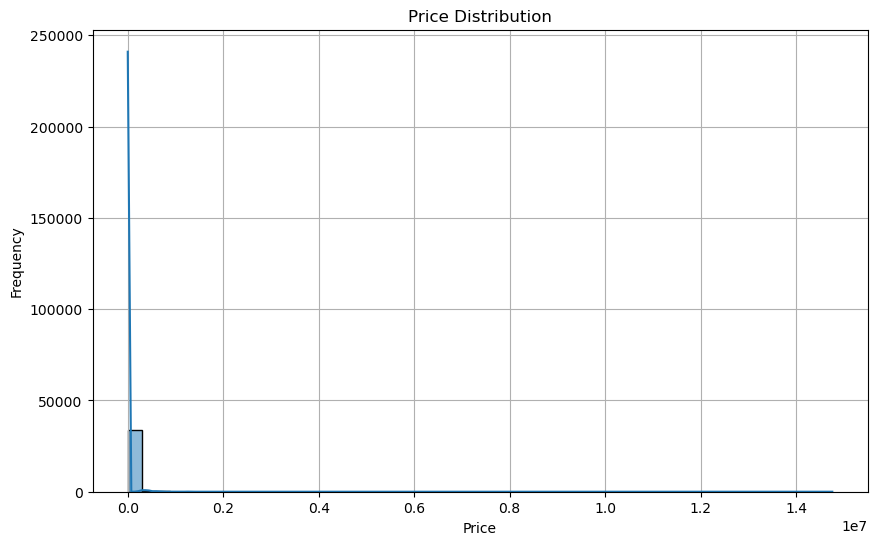

In [83]:
# Basic statistics about the Price column
print("Price statistics:\n")
print("Minimum Price     :", df['Price'].min())
print("Maximum Price     :", df['Price'].max())
print("Mean Price        :", df['Price'].mean())
print("Median Price      :", df['Price'].median())
print("25th Percentile   :", df['Price'].quantile(0.25))
print("75th Percentile   :", df['Price'].quantile(0.75))
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [86]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

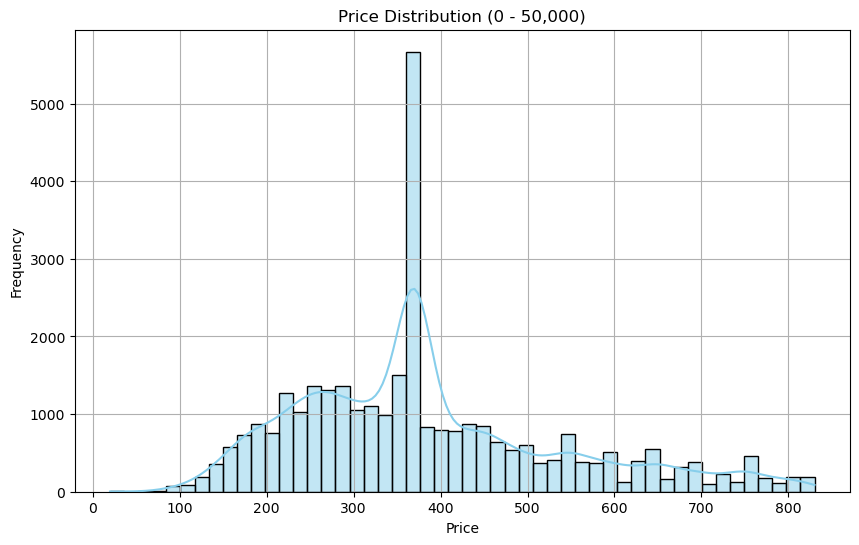

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=50, kde=True, color='skyblue')
plt.title('Price Distribution (0 - 50,000)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [89]:
# Separate target and features
y = df['Price']  # Capital P as per your column
X = df.drop(columns=['Price'])

print("✅ Target and features are ready!")
print("🎯 y (target):", y.name)
print("🧠 X shape:", X.shape)


✅ Target and features are ready!
🎯 y (target): Price
🧠 X shape: (32562, 176)


In [90]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data split complete!")
print("🧪 X_train shape:", X_train.shape)
print("🧪 X_test shape :", X_test.shape)
print("🎯 y_train shape:", y_train.shape)
print("🎯 y_test shape :", y_test.shape)


✅ Data split complete!
🧪 X_train shape: (26049, 176)
🧪 X_test shape : (6513, 176)
🎯 y_train shape: (26049,)
🎯 y_test shape : (6513,)


In [91]:
models = {
    "XGBoost": {
        "model": XGBRegressor(tree_method="hist", random_state=42),  # Remove device="cuda"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42),  # Remove device_type="gpu"
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6]
        }
    },
    "HistGradientBoosting": {
        "model": HistGradientBoostingRegressor(random_state=42),
        "params": {
            "max_iter": [100, 200],  # Note: parameter name is max_iter, not n_estimators
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),  # Remove task_type="GPU"
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    }
}

In [92]:
# Train & evaluate models
results = {}
for name, config in models.items():
    print(f"\n=== Tuning {name} ===")
    
    # GridSearchCV for best hyperparameters
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    start_time = time.time()
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    
    # Predict & evaluate
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store results
    results[name] = {
        "Best Params": grid.best_params_,
        "MSE": mse,
        "Time (s)": round(time.time() - start_time, 2)
    }
    
    print(f"Best Params: {grid.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"Training Time: {results[name]['Time (s)']}s")

# Display final results
print("\n=== Model Performance Summary ===")
results_df = pd.DataFrame(results).T
# Sort the models by MSE and display the performance
print(results_df[['MSE', 'Time (s)']].sort_values('MSE'))


=== Tuning XGBoost ===


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
MSE: 9333.5923
Training Time: 4.98s

=== Tuning LightGBM ===
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.336126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1176
[LightGBM] [Info] Number of data points in the train set: 17366, number of used features: 176
[LightGBM] [Info] Start training from score 383.141464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinu

Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
MSE: 10692.3797
Training Time: 23.14s

=== Model Performance Summary ===
                               MSE Time (s)
XGBoost                9333.592312     4.98
LightGBM               9639.522789    19.82
HistGradientBoosting   9723.851545     7.74
CatBoost              10692.379701    23.14
Random Forest         16021.955533    51.71


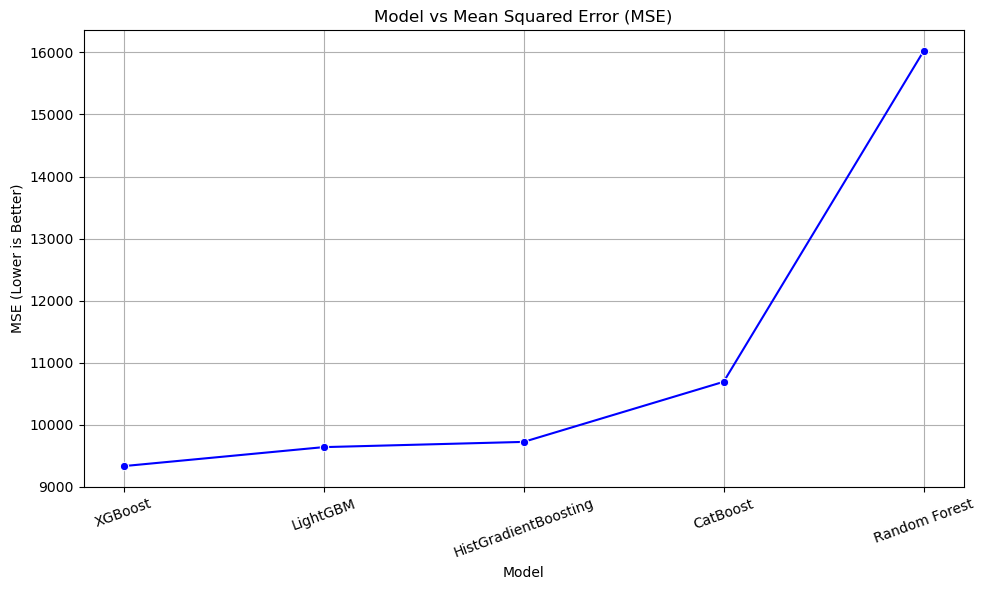

/tmp/ipykernel_22877/699800798.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_df, x='Model', y='Time (s)', palette='magma')


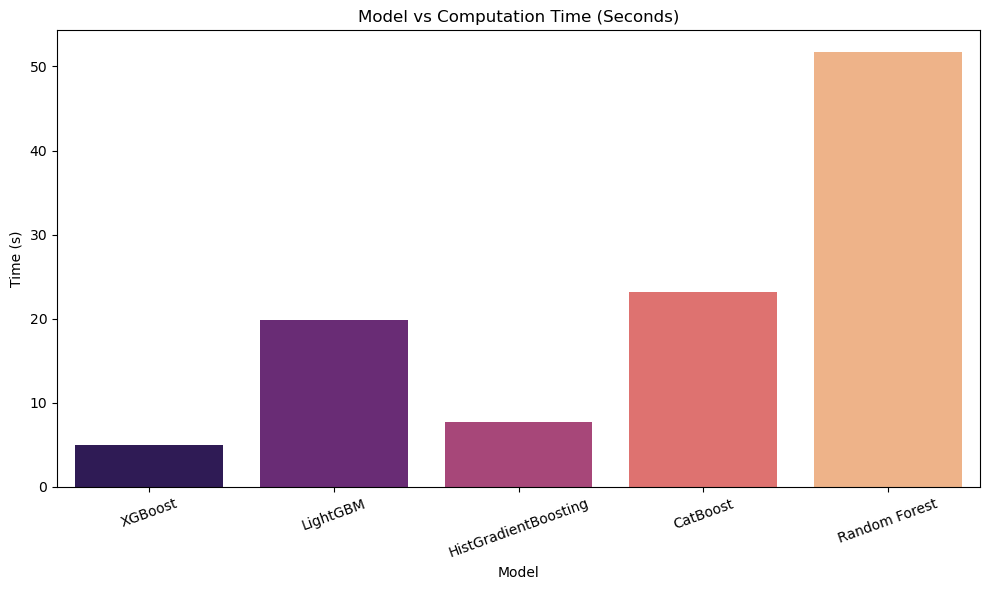

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by MSE (optional, for better visuals)
sorted_df = results_df[['MSE', 'Time (s)']].sort_values('MSE').reset_index()
sorted_df.rename(columns={'index': 'Model'}, inplace=True)

# Plot MSE
plt.figure(figsize=(10, 6))
sns.lineplot(data=sorted_df, x='Model', y='MSE', marker='o', color='blue')
plt.title('Model vs Mean Squared Error (MSE)')
plt.xticks(rotation=20)
plt.ylabel('MSE (Lower is Better)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot Time
plt.figure(figsize=(10, 6))
sns.barplot(data=sorted_df, x='Model', y='Time (s)', palette='magma')
plt.title('Model vs Computation Time (Seconds)')
plt.xticks(rotation=20)
plt.ylabel('Time (s)')
plt.xlabel('Model')
plt.tight_layout()
plt.show()
